In [1]:
!pip install scikit-optimize

In [2]:
!pip install scikit-learn
!pip install seaborn
!pip install scikit-optimize

In [4]:
import time
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
     

In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [6]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd

# Load the datasets
fake_news = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real_news = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

# Add labels (0=Real, 1=Fake)
fake_news['label'] = 1
real_news['label'] = 0

# Combine into one dataset
dataset = pd.concat([fake_news, real_news], axis=0)

# Shuffle the data to mix fake and real news
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Keep only relevant columns (text and label)
dataset = dataset[['text', 'label']]

# Save to a new CSV (optional)
dataset.to_csv("fake_news_dataset.csv", index=False)

In [8]:
from sklearn.model_selection import train_test_split

# Split into 80% training, 20% testing
train_df, test_df = train_test_split(
    dataset, 
    test_size=0.2, 
    random_state=42
)

# Save test data separately (for evaluation)
test_df.to_csv("test_news_data.csv", index=False)

In [9]:
df1=pd.read_csv('/kaggle/working/test_news_data.csv')
df2=pd.read_csv('/kaggle/working/fake_news_dataset.csv')
df2

,text,label
0,"21st Century Wire says Ben Stein, reputable pr...",1
1,WASHINGTON (Reuters) - U.S. President Donald T...,0
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,0
3,"On Monday, Donald Trump once again embarrassed...",1
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",0
...,...,...
44893,,1
44894,LONDON/TOKYO (Reuters) - British Prime Ministe...,0
44895,BERLIN (Reuters) - Chancellor Angela Merkel sa...,0
44896,Jesus f*cking Christ our President* is a moron...,1


In [10]:
df2.head()

,text,label
0,"21st Century Wire says Ben Stein, reputable pr...",1
1,WASHINGTON (Reuters) - U.S. President Donald T...,0
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,0
3,"On Monday, Donald Trump once again embarrassed...",1
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",0


In [11]:
print(df2.describe())

              label
count  44898.000000
mean       0.522985
std        0.499477
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Manual "setup" equivalent
X_train, X_test, y_train, y_test = train_test_split(
    df2['text'], df2['label'], 
    test_size=0.2,  # Same as train_size=0.8 in PyCaret
    random_state=42
)

# Text processing (like PyCaret's text_features)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Now ready for modeling (e.g., LogisticRegression)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35918, 5000)
(35918,)
(8980, 5000)
(8980,)


In [14]:
# Define a dictionary to store the results
results = {}

## Evaluating Various ML Models-

### 1.Logistic regression-

In [15]:
%%time
start_time = time.time()
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

end_time = time.time()
training_time = end_time - start_time

results['Logistic Regression'] = [accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred, average='weighted'),
                                  recall_score(y_test, y_pred, average='weighted'),
                                  f1_score(y_test, y_pred, average='weighted'),
                                  training_time]
print("Accuracy:", results['Logistic Regression'][0])
print("Precision:", results['Logistic Regression'][1])
print("Recall:", results['Logistic Regression'][2])
print("F1-score:", results['Logistic Regression'][3])
print("Training Time:", results['Logistic Regression'][4])
     

Accuracy: 0.9847438752783965
Precision: 0.9847792170167096
Recall: 0.9847438752783965
F1-score: 0.9847465624715999
Training Time: 2.5083463191986084
CPU times: user 9.5 s, sys: 9.64 ms, total: 9.51 s
Wall time: 2.53 s


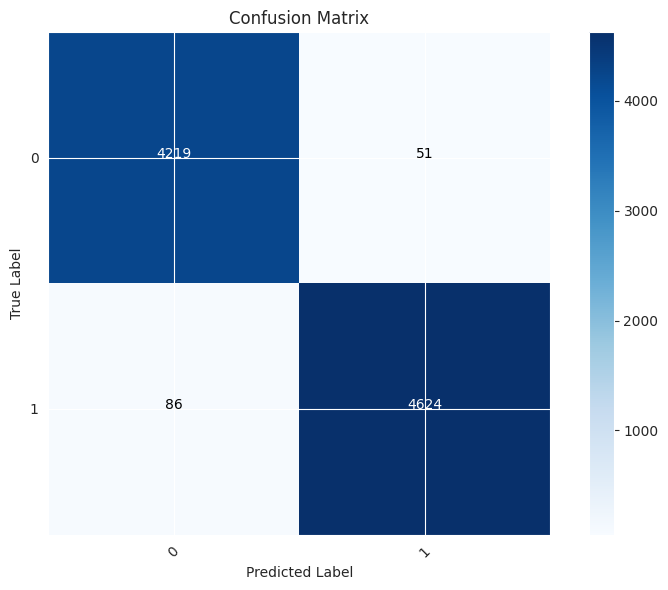

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
classes = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the cells of the confusion matrix with values
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [17]:
import numpy as np

# Iterate over each classifier
classifiers = {
    'Logistic Regression': logistic
}

for name, classifier in classifiers.items():
    try:
        # Predict using the classifier
        if name == 'LightGBM':  # For neural network model
            # Convert SparseTensor to dense numpy arrays
            X_test_dense = X_test.toarray()
            y_pred = np.round(classifier.predict(X_test_dense)).flatten()
        else:
            # Convert TF-IDF transformed sparse matrices to dense numpy arrays
            X_test_dense = X_test.toarray()
            y_pred = classifier.predict(X_test_dense)

        # Get indices of rows predicted as hate speech
        Fake_news_indices = np.where(y_pred == 1)[0]

        # Get the rows of speeches predicted as hate speech
        Fake_News_Detection_rows = df1.iloc[Fake_news_indices]

        # Display the hate speech rows
        print(f"Fake News Detection by {name} classifier:")
        print(Fake_News_Detection_rows)

        # Save the hate speech rows to a CSV file
        Fake_News_Detection_rows.to_csv(f"/kaggle/working/fake_news_dataset.csv", index=False)
    except AttributeError:
        print(f"AttributeError: Cannot predict using {name}.")

Fake News Detection by Logistic Regression classifier:
                                                   text  label
0     Well, that didn t take long. In the short time...      1
3     Print journalism and longstanding papers have ...      1
6                                                            1
7     Senator Rand Paul appeared on Bill Hemmer s Fo...      1
9     You d think that in the year 2016, companies w...      1
...                                                 ...    ...
8973  Tune in to the Alternate Current Radio Network...      1
8974  Donald Trump once bragged that he had  the bes...      1
8975                                                         1
8976  CNN announced it would be indefinitely banning...      1
8977  In this video White people are asked how they ...      1

[4675 rows x 2 columns]


In [18]:
from sklearn.metrics import classification_report, roc_auc_score

# Detailed performance report
print(classification_report(y_test, y_pred, 
                           target_names=['Real News', 'Fake News']))

# AUC-ROC score (for probabilistic predictions)
y_probs = logistic.predict_proba(X_test)[:, 1]
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_probs):.4f}")

              precision    recall  f1-score   support

   Real News       0.98      0.99      0.98      4270
   Fake News       0.99      0.98      0.99      4710

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

AUC-ROC Score: 0.9983


In [19]:
# Get top predictive words
feature_names = tfidf.get_feature_names_out()
coef_df = pd.DataFrame({'word': feature_names, 
                       'coefficient': logistic.coef_[0]})\
           .sort_values('coefficient', ascending=False)

print("Top words indicating Fake News:")
print(coef_df.head(10))

print("\nTop words indicating Real News:")
print(coef_df.tail(10))

Top words indicating Fake News:
          word  coefficient
3657      read     6.162745
2517      just     5.913391
2263     image     5.636618
1776  featured     5.608476
2008       gop     5.139566
2985        mr     4.866783
938        com     4.669545
2166   hillary     4.376603
1979     getty     4.204015
4874     watch     4.190073

Top words indicating Real News:
            word  coefficient
2955      monday    -4.077803
3093         nov    -4.341368
1919      friday    -4.377584
3800  republican    -4.918938
4570    thursday    -4.967553
4679     tuesday    -5.190446
4896   wednesday    -5.352168
4870  washington    -6.226330
3963        said   -16.731506
3858     reuters   -28.280596


In [20]:
import joblib
joblib.dump(logistic, 'fake_news_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']